In [86]:
%matplotlib inline

import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp

from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [92]:
import sys
import importlib

# Clear the module from cache
if "local_LFBOTmetric" in sys.modules:
    del sys.modules["local_LFBOTmetric"]

# Re-import and reload the updated module
import local_LFBOTmetric
importlib.reload(local_LFBOTmetric)

# Import updated classes and functions from the refactored module
from local_LFBOTmetric import (
    LFBOT_LC,
    generateLFBOTPopSlicer,
    LFBOTDetectMetric,
    LFBOTCharacterizeMetric,
    generateLFBOTTemplates
)


# Confirm path
print(local_LFBOTmetric.__file__)

import inspect
print("🔍 using generateLFBOTPopSlicer from:", inspect.getfile(generateLFBOTPopSlicer))



/Users/andradenebula/Documents/Research/Transient_Metrics/Stuff/AllTransient/local_LFBOTmetric.py
🔍 using generateLFBOTPopSlicer from: /Users/andradenebula/Documents/Research/Transient_Metrics/Stuff/AllTransient/local_LFBOTmetric.py


Generating shared LFBOT light curve templates...
 Saved synthetic LFBOT light curve templates to LFBOT_templates.pkl
Loaded LFBOT templates from LFBOT_templates.pkl
Generating shared LFBOT population...
YAY! UNIFORM SPHERE!
Saved LFBOT population to LFBOT_population.pkl

--- Running four_roll_v4.3.1_10yrs ---
Out of 3728 simulated LFBOT events, Rubin detected 36 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.1 ± 0.3 filters.
Saved 36 detected LFBOT light curves to AllTransient_MetricDetection/LFBOTs/LFBOT_ObsDataLC_four_roll_v4.3.1_10yrs.pkl
Saved summary CSV to AllTransient_MetricDetection/LFBOTs/LFBOT_ObsDataLC_four_roll_v4.3.1_10yrs_shortsummary.csv
Saved efficiency summary to AllTransient_MetricDetection/LFBOTs/local_efficiency_four_roll_v4.3.1_10yrs_LFBOT_per_filter.csv
Appended multi-band characterization efficiency to AllTransient_MetricDetection/LFBOTs/local_efficiency_four_roll_v4.3.1_10yrs_LFBOT_per_filter.csv
Saved combined plo

/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_3148/4042583956.py:63: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


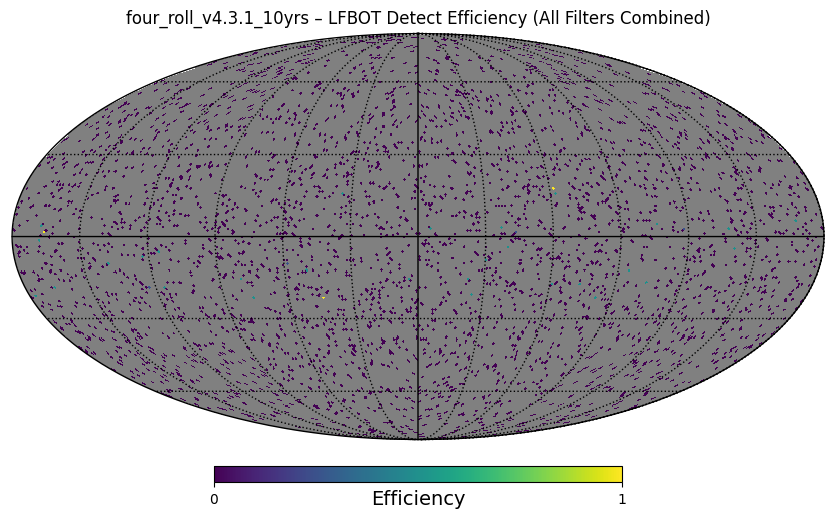

Saved combined plot to AllTransient_MetricDetection/LFBOTs/LFBOT_four_roll_v4.3.1_10yrs_Characterize_AllFilters_Efficiency.png


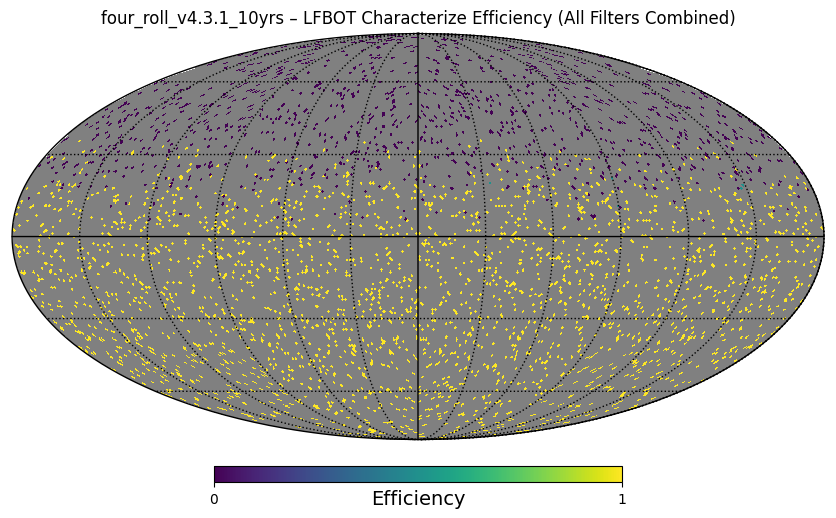


--- Running baseline_v4.3.1_10yrs ---
Out of 3728 simulated LFBOT events, Rubin detected 59 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.1 ± 0.3 filters.
Saved 59 detected LFBOT light curves to AllTransient_MetricDetection/LFBOTs/LFBOT_ObsDataLC_baseline_v4.3.1_10yrs.pkl
Saved summary CSV to AllTransient_MetricDetection/LFBOTs/LFBOT_ObsDataLC_baseline_v4.3.1_10yrs_shortsummary.csv
Saved efficiency summary to AllTransient_MetricDetection/LFBOTs/local_efficiency_baseline_v4.3.1_10yrs_LFBOT_per_filter.csv
Appended multi-band characterization efficiency to AllTransient_MetricDetection/LFBOTs/local_efficiency_baseline_v4.3.1_10yrs_LFBOT_per_filter.csv
Saved combined plot to AllTransient_MetricDetection/LFBOTs/LFBOT_baseline_v4.3.1_10yrs_Detect_AllFilters_Efficiency.png


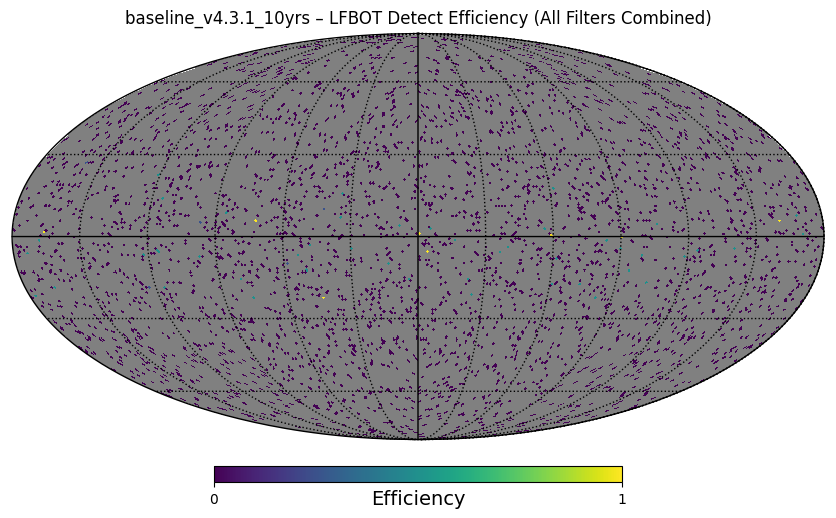

Saved combined plot to AllTransient_MetricDetection/LFBOTs/LFBOT_baseline_v4.3.1_10yrs_Characterize_AllFilters_Efficiency.png


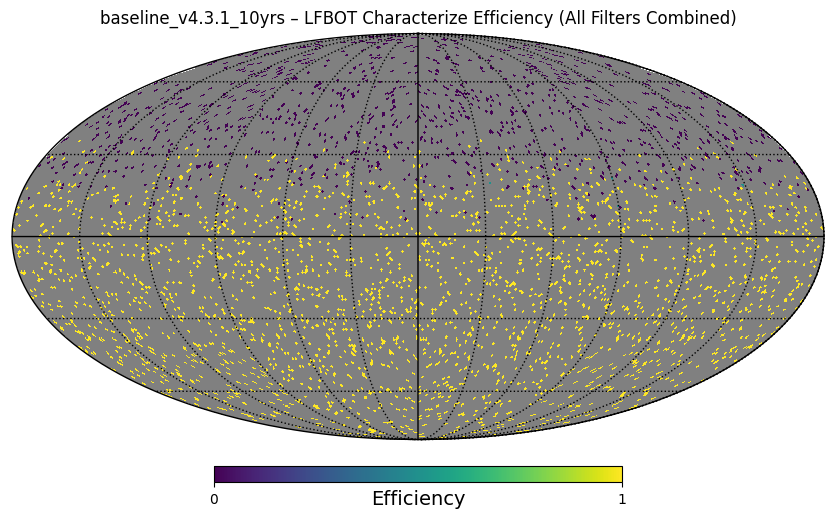

In [93]:
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
filters = ['g', 'r']  # Only g and r bands for LFBOTs

lfbot_pop_file = "LFBOT_population.pkl"
lfbot_templates_file = "LFBOT_templates.pkl"

dmin = 10
dmax = 600
gal_lat_cut = None

# (1) Generate templates separately if missing
if not os.path.exists(lfbot_templates_file):
    print("Generating shared LFBOT light curve templates...")
    generateLFBOTTemplates(save_to=lfbot_templates_file)

# (2) Now safely load the shared light curve templates
shared_lc_model = LFBOT_LC(load_from=lfbot_templates_file)

# (3) Load or generate the population
if not os.path.exists(lfbot_pop_file):
    print("Generating shared LFBOT population...")
    slicer = generateLFBOTPopSlicer(
        seed=42,
        d_min=dmin,
        d_max=dmax,
        num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut,
        save_to=lfbot_pop_file
    )
else:
    print("Loading existing LFBOT population...")
    slicer = generateLFBOTPopSlicer(load_from=lfbot_pop_file)

n_events = len(slicer.slice_points['distance'])

for cadence in cadences:
    runName = cadence
    db_path = f'{cadence}.db'
    opsdb = db_path

    outfile = f"AllTransient_MetricDetection/LFBOTs/local_efficiency_{cadence}_LFBOT.csv"
    outDir = "AllTransient_MetricDetection/LFBOTs/Metric_temp"
    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)

    print(f"\n--- Running {cadence} ---")

    # --- Per-filter metrics ---
    per_filter_metrics = OrderedDict()

    for filt in filters:
        detect = LFBOTDetectMetric(metricName=f"LFBOT_Detect_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        char = LFBOTCharacterizeMetric(metricName=f"LFBOT_Characterize_{filt}", filter_include=[filt], lc_model=shared_lc_model)

        per_filter_metrics[f"LFBOT_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')
        per_filter_metrics[f"LFBOT_Characterize_{filt}"] = metric_bundles.MetricBundle(char, slicer, '')

    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

    # --- Detection statistics summary ---

    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"LFBOT_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"LFBOT_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])

    detected_mask = n_filters_detected_per_event >= 1

    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])

    print(f"Out of {n_events} simulated LFBOT events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")

    # --- Collect observational data for detected LFBOT light curves ---
    detected_lightcurves = []
    collected_sids = set()
    for filt in filters:
        metric = per_filter_metrics[f"LFBOT_Detect_{filt}"].metric
        if hasattr(metric, 'obs_records'):
            for sid, record in metric.obs_records.items():
                if sid not in collected_sids:
                    detected_lightcurves.append(record)
                    collected_sids.add(sid)

    if detected_lightcurves:
        out_lc = f"AllTransient_MetricDetection/LFBOTs/LFBOT_ObsDataLC_{cadence}.pkl"
        os.makedirs(os.path.dirname(out_lc), exist_ok=True)
        with open(out_lc, "wb") as f:
            pickle.dump(detected_lightcurves, f)
        print(f"Saved {len(detected_lightcurves)} detected LFBOT light curves to {out_lc}")

        out_csv = out_lc.replace(".pkl", "_shortsummary.csv")
        with open(out_csv, "w") as out:
            out.write("sid,peak_mjd,peak_mag,first_det_mjd,last_det_mjd,rise_time_days,fade_time_days,ra,dec,distance_Mpc\n")
            for rec in detected_lightcurves:
                out.write(f"{rec['sid']},{rec['peak_mjd']:.5f},{rec['peak_mag']:.3f},{rec['first_det_mjd']:.5f},{rec['last_det_mjd']:.5f},{rec['rise_time_days']:.5f},{rec['fade_time_days']:.5f},{rec['ra']:.5f},{rec['dec']:.5f},{rec['distance_Mpc']:.2f}\n")
        print(f"Saved summary CSV to {out_csv}")


    # --- Output efficiency per filter ---
    with open(outfile.replace(".csv", "_per_filter.csv"), "w") as out:
        out.write("dist_min_Mpc, dist_max_Mpc, metric, filter, found, total, efficiency\n")
        for key in per_filter_metrics:
            if "Detect" in key:  # <-- Only write Detect metrics per filter
                for filt in filters:
                    if filt not in key:
                        continue
                    values = per_filter_metrics[key].metric_values
                    mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)
    
                    found = np.sum((values == 1) & mask)
                    total = len(values)
                    efficiency = found / total if total > 0 else 0.0
                    metric_base = key.split('_')[0] + '_' + key.split('_')[1]
                    out.write(f"{dmin}, {dmax}, {metric_base}, {filt}, {found}, {total}, {efficiency:.4f}\n")
    
    print(f"Saved efficiency summary to {outfile.replace('.csv', '_per_filter.csv')}")


    # --- Append Multi-band Characterization to CSV ---
    multi_band_characterized = np.zeros(n_events, dtype=bool)
    
    for filt in filters:
        key = f"LFBOT_Characterize_{filt}"
        if key not in per_filter_metrics:
            continue
        char_values = per_filter_metrics[key].metric_values
        mask = ~char_values.mask if hasattr(char_values, 'mask') else np.ones(len(char_values), dtype=bool)
        multi_band_characterized |= (char_values == 1) & mask
    
    found = np.sum(multi_band_characterized)
    total = n_events
    efficiency = found / total if total > 0 else 0.0
    
    with open(outfile.replace(".csv", "_per_filter.csv"), "a") as out:
        out.write("# Multi-band Metrics\n")
        out.write(f"{dmin}, {dmax}, LFBOT_Characterize_MultiBand, MultiBand, {found}, {total}, {efficiency:.4f}\n")
    
    print(f"Appended multi-band characterization efficiency to {outfile.replace('.csv', '_per_filter.csv')}")
    
    # --- Healpix plots for Detect and Characterize Multi-band ---
    
    for metric_type in ['Detect', 'Characterize']:
        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)
    
        ra_rad = np.radians(slicer.slice_points['ra'])
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)
    
        if metric_type == 'Detect':
            for filt in filters:
                key = f"LFBOT_Detect_{filt}"
                if key not in per_filter_metrics:
                    continue
                values = per_filter_metrics[key].metric_values
                mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)
    
                for i, pix in enumerate(pix_inds):
                    injected_map[pix] += 1
                    if (values[i] == 1) and mask[i]:
                        detected_map[pix] += 1
    
        elif metric_type == 'Characterize':
            characterized_multi = np.zeros(len(pix_inds), dtype=bool)
    
            for filt in filters:
                key = f"LFBOT_Characterize_{filt}"
                if key not in per_filter_metrics:
                    continue
                values = per_filter_metrics[key].metric_values
                mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)
    
                characterized_multi |= ((values == 1) & mask)
    
            for i, pix in enumerate(pix_inds):
                injected_map[pix] += 1
                if characterized_multi[i]:
                    detected_map[pix] += 1
    
        # Now build efficiency map
        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN
    
        title = f"{runName} – LFBOT {metric_type} Efficiency (All Filters Combined)"
        hp.mollview(
            eff_map,
            title=title,
            unit='Efficiency',
            cmap='viridis'
        )
        hp.graticule()
    
        plot_filename = f"AllTransient_MetricDetection/LFBOTs/LFBOT_{runName}_{metric_type}_AllFilters_Efficiency.png"
        os.makedirs(os.path.dirname(plot_filename), exist_ok=True)
        plt.savefig(plot_filename, bbox_inches='tight')
        print(f"Saved combined plot to {plot_filename}")
    
        plt.show()


    typefile = f"AllTransient_MetricDetection/LFBOTs/type_LFBOT_{cadence}_multi_filter.csv"

    with open(typefile, "w") as out:
        out.write("index,n_filters_detected,n_filters_characterized\n")  
        for i in range(n_events):
            d = sum(per_filter_metrics[f"LFBOT_Detect_{f}"].metric_values[i] == 1 and not per_filter_metrics[f"LFBOT_Detect_{f}"].metric_values.mask[i] for f in filters)
            c = sum(per_filter_metrics[f"LFBOT_Characterize_{f}"].metric_values[i] == 1 and not per_filter_metrics[f"LFBOT_Characterize_{f}"].metric_values.mask[i] for f in filters)
            out.write(f"{i},{d},{c}\n")



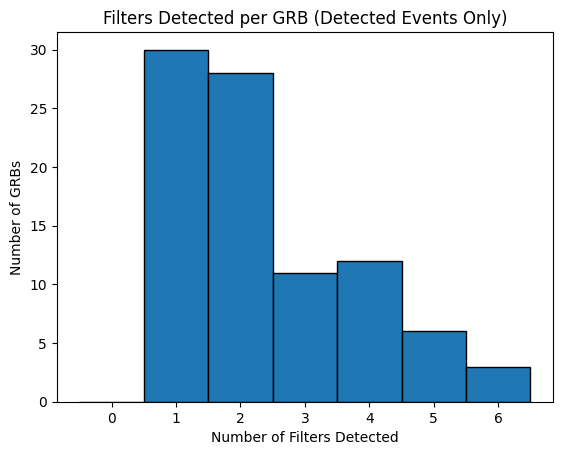

In [55]:
import matplotlib.pyplot as plt

# Visualize number of filters per detected GRB
plt.hist(n_filters_detected_per_event[detected_mask], bins=np.arange(8)-0.5, edgecolor='black')
plt.xlabel("Number of Filters Detected")
plt.ylabel("Number of GRBs")
plt.title("Filters Detected per GRB (Detected Events Only)")
plt.show()



In [106]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
from rubin_sim.maf.slicers import UserPointsSlicer
import pickle

def sample_lfbot_rate(t_start, t_end, d_min, d_max, rate_density=50e-9):
    years = (t_end - t_start) / 365.25
    z_min = z_at_value(cosmo.comoving_distance, d_min * u.Mpc)
    z_max = z_at_value(cosmo.comoving_distance, d_max * u.Mpc)
    V = cosmo.comoving_volume(z_max).to(u.Mpc**3).value - cosmo.comoving_volume(z_min).to(u.Mpc**3).value
    return np.random.poisson(rate_density * V * years)

def generateLFBOTPopSlicer_experiment(t_start=1, t_end=3652, seed=42,
                                      d_min=10, d_max=1000, num_lightcurves=1000,
                                      gal_lat_cut=None, rate_density=50e-9):
    rng = np.random.default_rng(seed)
    n_events = sample_lfbot_rate(t_start, t_end, d_min, d_max, rate_density=rate_density)

    ra = rng.uniform(0, 360, n_events)
    z = rng.uniform(-1, 1, n_events)
    dec = np.degrees(np.arcsin(z))
    dec = np.clip(dec, -89.9999, 89.9999)
    dec_rad = np.radians(dec)

    slicer = UserPointsSlicer(ra=ra, dec=dec_rad, badval=0)
    slicer.slice_points['ra'] = ra
    slicer.slice_points['dec'] = dec_rad

    distances = rng.uniform(d_min, d_max, n_events)
    peak_times = rng.uniform(t_start, t_end, n_events)
    file_indx = rng.integers(0, num_lightcurves, n_events)

    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    sfd = SFDQuery()
    ebv_vals = sfd(coords)

    slicer.slice_points['distance'] = distances
    slicer.slice_points['peak_time'] = peak_times
    slicer.slice_points['file_indx'] = file_indx
    slicer.slice_points['ebv'] = ebv_vals
    slicer.slice_points['gall'] = coords.galactic.l.deg
    slicer.slice_points['galb'] = coords.galactic.b.deg

    return slicer


# --- CONFIGURATION ---
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
filters = ['g', 'r']
dmin = 10
dmax = 600
rate_density_boost = 10  # Boost factor ×10
seed = 42
n_lightcurves = 1000

# Temporary LFBOT slicer with boosted rate
slicer = generateLFBOTPopSlicer_experiment(
    t_start=1, t_end=3652,
    seed=seed,
    d_min=dmin,
    d_max=dmax,
    num_lightcurves=n_lightcurves,
    gal_lat_cut=None,
    rate_density=420e-9 * rate_density_boost
)

n_events = len(slicer.slice_points['distance'])
shared_lc_model = LFBOT_LC(load_from="LFBOT_templates.pkl")  # Load templates normally

# --- Loop over cadences ---
for cadence in cadences:
    print(f"\n--- Running {cadence} ---")

    per_filter_metrics = OrderedDict()

    for filt in filters:
        detect = LFBOTDetectMetric(metricName=f"LFBOT_Detect_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        per_filter_metrics[f"LFBOT_Detect_{filt}"] = MetricBundle(detect, slicer, '')

    opsdb = f"{cadence}.db"  # ✅ correct style matching your metric
    resultsDb = ResultsDb(out_dir="temp_outdir")
    
    pf_group = MetricBundleGroup(per_filter_metrics, opsdb, "temp_outdir", resultsDb)
    pf_group.run_all()

    # --- Detection statistics ---
    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"LFBOT_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"LFBOT_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])

    detected_mask = n_filters_detected_per_event >= 1

    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask]) if n_detected > 0 else 0.0
    std_filters = np.std(n_filters_detected_per_event[detected_mask]) if n_detected > 0 else 0.0

    # Poisson statistical error
    statistical_error = np.sqrt(n_detected)

    # --- Final Output ---
    print(f"Out of {n_events} simulated LFBOT events, Rubin detected {n_detected} ± {statistical_error:.1f} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


Loaded LFBOT templates from LFBOT_templates.pkl

--- Running four_roll_v4.3.1_10yrs ---


/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_3148/3587390631.py:90: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 38365 simulated LFBOT events, Rubin detected 611 ± 24.7 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.1 ± 0.4 filters.

--- Running baseline_v4.3.1_10yrs ---
Out of 38365 simulated LFBOT events, Rubin detected 588 ± 24.2 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.1 ± 0.4 filters.
